# A Notebook for complete dev of a Resnet based model to predict the presence of colors

In [1]:
# Import packages and functions

import numpy as np
import pandas as pd
from PIL import Image as Image2
import matplotlib.pyplot as plt
import time
import argparse
import yaml
import pickle
from datetime import datetime

import torch
from transformers import ViTFeatureExtractor
from pytorch_data import *
from pytorch_models import *
from sklearn.metrics import confusion_matrix

import torch
import sys
#sys.path.insert(1, '/home/lmeyers/beeid_clean_luke/PYTORCH_CODE/')
#sys.path.insert(2, '/home/lmeyers/beeid_clean_luke/KEY_CODE_FILES/')

from pytorch_resnet50_conv3 import resnet50_convstage3
from data import prepare_for_triplet_loss

import numpy as np
import pandas as pd
from PIL import Image as Image2
import matplotlib.pyplot as plt

import torch.nn.parallel
import sys 
import os
import wandb

from torcheval.metrics.functional import binary_accuracy, binary_precision,binary_recall
from torcheval.metrics.functional import binary_f1_score
 

 


/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-25 21:02:09.621905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 21:02:10.768741: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/lmeyers/anaconda3/envs/mlenv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.

In [5]:
#load config file params:
config_file = '/home/lmeyers/ReID_complete/pytorch_train_and_eval_color_detect.yml'
verbose = True

try:
    with open(config_file) as f:
        config = yaml.safe_load(f)
    model_config = config['model_settings'] # settings for model building
    train_config = config['train_settings'] # settings for model training
    data_config = config['data_settings'] # settings for data loading
    eval_config = config['eval_settings'] # settings for evaluation
    torch_seed = config['torch_seed']
    verbose = config['verbose']
except Exception as e:
    print('ERROR - unable to open experiment config file. Terminating.')
    print('Exception msg:',e)
if verbose:
    # ADD PRINT OF DATE AND TIME
    now = datetime.now() # current date and time
    dt = now.strftime("%y-%m-%d %H:%M")
    print(f'Date and time when this experiment was started: {dt}')
    print(f'Date and time when this experiment was started: {dt}')
    print("Data Settings:")
    print(data_config)
    print("Train Settings:")
    print(train_config)
    print("Model Settings:")
    print(model_config)

Date and time when this experiment was started: 23-09-25 21:05
Date and time when this experiment was started: 23-09-25 21:05
Data Settings:
{'dataset': 'multicolor', 'split_type': 'closed', 'fname_col': 'mask_filename', 'label_col': 'ID', 'cropped': False, 'crop_top': None, 'crop_left': None, 'crop_height': None, 'crop_width': None, 'input_size': [200, 150], 'batch_size': 64, 'aug_p': 0.3, 'datafiles': {'train': '/home/lmeyers/ReID_complete/multicolor_train_all_updated_labelDependent_trackIndependent_timeSorted.csv', 'valid': '/home/lmeyers/ReID_complete/multicolor_valid_all_updated_labelDependent_trackIndependent_timeSorted.csv', 'test': '/home/lmeyers/ReID_complete/multicolor_test_all_updated_labelDependent_trackIndependent_timeSorted.csv', 'reference': None, 'query': None, 'gallery': None}, 'n_distractors': 9, 'image_id_col': 'image_id', 'gallery_id': 'gallery_id', 'iteration_id': 'iteration_id'}
Train Settings:
{'learning_rate': 0.001, 'num_epochs': 1500, 'margin': 0.2, 'print_k':

In [6]:
## load data

# setting torch seed
torch.manual_seed(torch_seed)

train_fname = data_config['datafiles']['train']
df_train = pd.read_csv(train_fname)
dft_train = prepare_for_triplet_loss(df_train, data_config['label_col'], data_config['fname_col'])

# BUILD DATASET AND DATALOADER
train_dataset = ColorMap(dft_train, 'filename', 'label',data_config['input_size'],'train','/home/lmeyers/ReID_complete/milticolor_color_map.json')
bs=64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False)
batch = next(iter(train_dataloader))

if verbose:
    try:
        batch = next(iter(train_dataloader))
        print(f'Batch image shape: {batch["image"].shape()}')
        print(f'Batch label shape: {batch["label"].shape()}')
    except Exception as e:
        print('ERROR - could not print out batch properties')
        print(f'Error msg: {e}')

AttributeError: shape

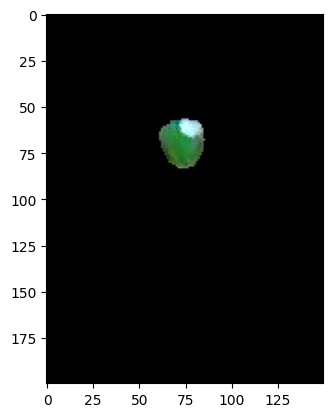

In [101]:
## Display sample of training Dataset 

image_to_query = 0
i_tensor = train_dataset[image_to_query]['image']


i_np = np.array(i_tensor)
batch_i_np = np.expand_dims(i_np, axis=0)
i = np.transpose(i_np,[1,2,0])

plt.imshow(i)
plt.show()

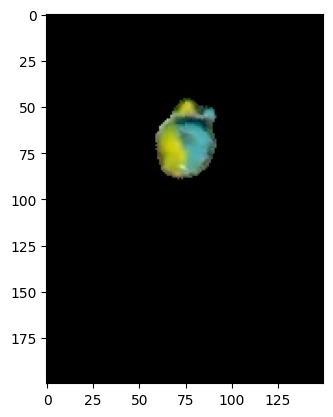

In [56]:
## load validation dataset 
valid_fname = data_config['datafiles']['valid']
df_valid = pd.read_csv(valid_fname)
dft_valid = prepare_for_triplet_loss(df_valid,data_config['label_col'],data_config['fname_col'])

# BUILD DATASET AND DATALOADER
valid_dataset = ColorMap(dft_valid, 'filename', 'label',data_config['input_size'],'valid','/home/lmeyers/ReID_complete/milticolor_color_map.json')
bs=64
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=False)
batch = next(iter(valid_dataloader))

# DISPLAY SAMPLE OF VALIDATION DATASET
v_sample_tensor = valid_dataset[image_to_query]['image']
v_np = np.array(v_sample_tensor)
batch_v_np = np.expand_dims(v_np, axis=0)
i = np.transpose(v_np,[1,2,0])

plt.imshow(i)
plt.show()

In [57]:
## Build model and load to device:
num_classes = model_config['num_labels']
model = build_model(model_config)

#add color class detector output to model:
model = nn.Sequential(
    model,
    nn.Linear(128, num_classes),
    nn.Sigmoid())

optimizer = torch.optim.Adam(model.parameters(), lr=train_config['learning_rate'])
loss_fn = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if verbose:
    print(f'Device: {device}')
model.to(device)


Device: cuda


Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [60]:
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5))

In [61]:

##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_predictions(model, dataloader, loss_fn, device, feature_extractor=None):
    predictions = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image']
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images])
                images = torch.tensor(images, dtype=torch.float)
            labels = batch['label'].to(device)
            outputs = model(images.to(device))
            loss += loss_fn(outputs, labels).detach().cpu().numpy()
            predictions += list(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    predictions = np.array(predictions)
    all_labels = np.array(all_labels)
    loss/=k
    return predictions, all_labels, loss
##########################################################################################

output = torch.tensor([[0.1836, 0.1990, 0.1784, 0.1853, 0.4892, 0.4804, 0.4951, 0.4842, 0.5116,
        0.5112, 0.7208, 0.5219, 0.5184],[0.1836, 0.1990, 0.1784, 0.1853, 0.4892, 0.4804, 0.4951, 0.4842, 0.5116,
        0.5112, 0.7208, 0.5219, 0.5184]])

label = torch.tensor([[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]])


import torch

def calculate_confusion_matrix(predictions, ground_truth):
    """
    Calculate confusion matrix for binary classification.

    Args:
        predictions (torch.Tensor): Tensor of binary predictions (0 or 1).
        ground_truth (torch.Tensor): Tensor of ground truth labels (0 or 1).

    Returns:
        dict: A dictionary with TP, TN, FP, and FN counts.
    """
    # Ensure both inputs are tensors
    if not isinstance(predictions, torch.Tensor) or not isinstance(ground_truth, torch.Tensor):
        raise ValueError("Both inputs must be PyTorch tensors.")

    # Ensure the tensors have the same shape
    if predictions.shape != ground_truth.shape:
        raise ValueError("Input tensors must have the same shape.")

    # Round prediction to be binary like truth
    predictions = torch.round(predictions)

    # Calculate confusion matrix counts
    tp = torch.sum((predictions == 1.0) & (ground_truth == 1.0)).item()
    tn = torch.sum((predictions == 0.0) & (ground_truth == 0.0)).item()
    fp = torch.sum((predictions == 1.0) & (ground_truth == 0.0)).item()
    fn = torch.sum((predictions == 0.0) & (ground_truth == 1.0)).item()

    # Create and return the dictionary
    confusion_matrix = {
        'True Positives (TP)': tp,
        'True Negatives (TN)': tn,
        'False Positives (FP)': fp,
        'False Negatives (FN)': fn
    }

    return confusion_matrix

############################################################################################
# FUNCTION TO EVAL TWO COLOR MAPS, INCLUDING PRECISION, RECALL, F1 AND PER CLASS ACC

def getMetrics(predictions,truth):
    '''
    A function to return 3 evaluation metrics on each sample.
    
    Args:
        predictions (torch.Tensor): Tensor of binary predictions (0 or 1).
        truth (torch.Tensor): Tensor of ground truth labels (0 or 1).
    Returns:
        accuracy(torch.Tensor): Tensor of average # of classes that are predicted correctly (TP+TN/All)
        precision(torch.Tensor): tensor of average precision
        recall(torch.Tensor): Tensor of average recall
    '''
    if not isinstance(predictions, torch.Tensor) or not isinstance(truth, torch.Tensor):
        raise ValueError("Both inputs must be PyTorch tensors.")

    # Ensure the tensors have the same shape
    if predictions.shape != truth.shape:
        raise ValueError("Input tensors must have the same shape.")

    acc = []
    precision = []
    recall = []
    for t in range(len(predictions)):
        acc.append(binary_accuracy(torch.round(predictions[t]),truth[t]))
        precision.append(binary_precision(torch.round(predictions[t]),truth[t]))
        recall.append(binary_recall(torch.round(predictions[t]).long(),truth[t].long()))
    acc = torch.mean(torch.tensor(acc))
    precision = torch.tensor(precision).mean()
    recall = torch.tensor(recall).mean()
    return acc, precision, recall



#print(getMetrics(output,label))


In [102]:
resume_training = False
#"""
if resume_training == True: 
    experiment = wandb.init(project="color_detect", entity="lqmeyers",resume=True)
else:
    experiment = wandb.init(project="color_detect", entity="lqmeyers")
#"""

# load latest saved checkpoint if resuming a failed run
if resume_training == True: 
    saved = os.listdir(os.path.dirname(model_config['model_path'])+r'/checkpoints/')
    check_array = []
    for f in saved:
        check_array.append(f[:-4])
    check_array = np.array(check_array,dtype=np.int64)
    most_recent_epoch = np.max(check_array) #find most recent checkpoint
    print(f'Resuming training from saved epoch: {most_recent_epoch}')
    most_recent_model = os.path.dirname(model_config['model_path'])+r'/checkpoints/'+str(most_recent_epoch)+'.pth'
    print(f'Loading saved checkpoint model {most_recent_model}')
    model = torch.load(most_recent_model)


# if resuming training set epoch number
if resume_training == True:
    epoch_range = range(train_config['num_epochs'])[most_recent_epoch:]
else:
    epoch_range = range(train_config['num_epochs'])

    # Train the model
if verbose:
    print('Training model...')

print_k = train_config['print_k']
start = time.time()
for epoch in epoch_range: 
    running_loss = 0.0
    for k, data in enumerate(train_dataloader):
        images = data['image'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #"""
        experiment.log({
            'train loss': loss.item(),
            'epoch': epoch
            #'learning rate' : lr
        })
        #"""
        if (k+1)%print_k == 0:
            with torch.no_grad():
                train_acc, train_prec, train_recall = getMetrics(outputs,labels)
                valid_predictions, valid_labels, valid_loss = get_predictions(model, valid_dataloader, loss_fn, device)
                valid_acc, valid_prec, valid_recall = getMetrics(torch.tensor(valid_predictions),torch.tensor(valid_labels))
                #"""
                experiment.log({'epoch':(epoch+1),
                                'train loss': (running_loss/print_k),
                                'train accuracy':train_acc,
                                'train precision':train_prec,
                                'train recall': train_recall,
                                'validation loss': valid_loss,
                                'validation accuracy': valid_acc,
                                'validation precision': valid_prec,
                                'valdiation recall': valid_recall})
                                #"""
                print(f'[{epoch + 1}, {k + 1:5d}] loss: {running_loss/print_k:.4f} | train_acc: {train_acc:.4f} | train_recall: {train_recall:.4f}| val_loss: {valid_loss:.4f} | val_acc: {valid_acc:.4f} | val_recall{valid_recall:.4f}')
                running_loss= 0.0
        #"""

        """
        if (k+1)%print_k == 0:
            with torch.no_grad():
                valid_outputs, valid_labels, valid_loss = get_embeddings(model, valid_dataloader, loss_fn, miner, device, feature_extractor)
                print(f'[{epoch + 1}, {k + 1:5d}] train_loss: {running_loss/print_k:.4f} | val_loss: {valid_loss:.4f}')
                running_loss=0.0
                #scheduler.step(valid_loss)
                #current_lr = optimizer.param_groups[0]['lr']
                experiment.log({'valid loss': valid_loss, })
                                # 'learning rate': current_lr})
        """
    if epoch % train_config['save_checkpoint_freq'] == 0 or (epoch-1) == train_config['num_epochs']:
            if os.path.dirname(model_config['model_path']) is not None:
                print('Saving checkpoint',epoch)
                if not os.path.exists(os.path.dirname(model_config['model_path'])+r'/checkpoints/'):
                    os.mkdir(os.path.dirname(model_config['model_path'])+r'/checkpoints/')
                torch.save(model,(os.path.dirname(model_config['model_path'])+r'/checkpoints/'+str(epoch)+".pth"))

stop = time.time()
print(f'Total train time: {(stop-start)/60}min')

epoch,▁▁▁▁▁▁▁▁
train loss,█▁▂▆▃▅▅▆
epoch,0
train loss,1.19223


Training model...


RuntimeError: stack expects each tensor to be equal size, but got [3, 200, 150] at entry 0 and [1, 200, 150] at entry 15

In [33]:

"""
def evaluate_color_predictions(predicted,truth):
    '''
    Function to return evaluation metrics for two binary predictions
        Inputs:
                predicted(torch.tensor): an array of float32 predicted probabilities 
                truth(torch.tensor):an array of binary truth values as float32
        
        Outputs:
        precision(float) : % of 
        recall
        F1
        
    '''
    matches = torch.logical_and(torch.round(predicted),truth)
    accuracy = (matches.float().mean())
    




    for i in range(len(labels[0])):
        values_at_index = [subarray[i] for subarray in matches]
        class_mean = torch.tensor(values_at_index).float().mean()
        if k == 0:
            class_acc[i] = [class_mean]
        else:
            class_acc[i].append(class_mean)
    for c in class_acc:
        print('Class',c,'Acc:',torch.tensor(class_acc[c]).float().mean())
    print("Total Acc:",torch.tensor(acc).mean())
   
    
    return
    

#evaluate_color_predictions(output,label)

print((torch.round(output) == label).float().mean()) #this method can handle batches
"""


'\ndef evaluate_color_predictions(predicted,truth):\n    \'\'\'\n    Function to return evaluation metrics for two binary predictions\n        Inputs:\n                predicted(torch.tensor): an array of float32 predicted probabilities \n                truth(torch.tensor):an array of binary truth values as float32\n        \n        Outputs:\n        precision(float) : % of \n        recall\n        F1\n        \n    \'\'\'\n    matches = torch.logical_and(torch.round(predicted),truth)\n    accuracy = (matches.float().mean())\n    \n\n\n\n\n    for i in range(len(labels[0])):\n        values_at_index = [subarray[i] for subarray in matches]\n        class_mean = torch.tensor(values_at_index).float().mean()\n        if k == 0:\n            class_acc[i] = [class_mean]\n        else:\n            class_acc[i].append(class_mean)\n    for c in class_acc:\n        print(\'Class\',c,\'Acc:\',torch.tensor(class_acc[c]).float().mean())\n    print("Total Acc:",torch.tensor(acc).mean())\n   \n  

In [34]:
!cp /home/lmeyers/ReID_complete/checkpoints/1400.pth /home/lmeyers/ReID_complete/wandb/latest-run/files/model.pth

In [43]:
## load test dataset 
test_fname = data_config['datafiles']['test']
df_test = pd.read_csv(test_fname)
dft_test = prepare_for_triplet_loss(df_test,data_config['label_col'],data_config['fname_col'])

# BUILD DATASET AND DATALOADER
test_dataset = ColorMap(dft_test, 'filename', 'label',data_config['input_size'],'test','/home/lmeyers/ReID_complete/milticolor_color_map.json')
bs=64
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
batch = next(iter(test_dataloader))

#load saved model:
model = torch.load('/home/lmeyers/ReID_complete/wandb/latest-run/files/model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if verbose:
    print(f'Device: {device}')
model.to(device)

# PERFORM INFERENCE
with torch.no_grad():
    acc = []
    prec = []
    rec = []
    vals = {}
    corr = []
    for k, data in enumerate(test_dataloader):
        if verbose: 
            print('Performing Inference on Batch',k)
        images = data['image'].to(device)
        # get labels
        labels = data['label'].to(device)
        outputs = model(images)
        #matches = (torch.round(outputs) == labels)
        #print(matches.shape)
        #correct = np.all(matches,axis=1,out=None)
        #print(correct.shape)
        #matches = torch.logical_and(torch.round(outputs),labels)
        predictions = torch.round(outputs)
        mapping_array = np.zeros_like(predictions.cpu())  # Initialize with zero TN
        # Set elements to 1 where both binary arrays have value 1
        mapping_array[(predictions.cpu() == 1) & (labels.cpu() == 1)] = 1 #TP
        mapping_array[(predictions.cpu() == 1) & (labels.cpu() == 0)] = 2 #FP
        mapping_array[(predictions.cpu() == 0) & (labels.cpu() == 1)] = 3 #FN
        #accuracy = (matches.float().mean())
        accuracy, precision, recall = getMetrics(outputs,labels)
        acc.append(accuracy)
        prec.append(precision)
        rec.append(recall)
        corrects = [2 and 3 not in sample for sample in mapping_array]
        corr = np.concatenate((corr,corrects))
        for i in range(len(labels[0])):
            values_at_index = [subarray[i] for subarray in mapping_array]
            #print('Batch',k,'Class',i,values_at_index)
            if k == 0:
                vals[i] = values_at_index  
            else:
                vals[i] = np.concatenate((vals[i],values_at_index))
    for c in vals:
            TP = torch.sum(torch.tensor(vals[c]) == 1)
            TN = torch.sum(torch.tensor(vals[c]) == 0)
            FP = torch.sum(torch.tensor(vals[c]) == 2)
            FN = torch.sum(torch.tensor(vals[c]) == 3)
            All = torch.tensor(len(vals[c]))
            class_acc = (TP + TN)/ All
            class_prec=  (TP)/(TP+FP)
            class_rec = (TP)/(TP+FN)
            print('Class',c,'TP:',int(TP),'FN:',int(FN),'FP:',int(FP),'TN:',int(TN))#'Acc:',torch.tensor(class_acc).float().mean(),'Precision:',torch.tensor(class_prec).float().mean(),'Recall:',torch.tensor(class_rec).float().mean(),)
    print('Total Correct Samples',np.sum(corr),"out of",len(corr),'=',(np.sum(corr)/len(corr)))
    print("Total Acc:",torch.tensor(acc).mean())
    print("Total Precision:",torch.tensor(prec).mean())
    print("Total Recall:",torch.tensor(rec).mean())
       

Device: cuda
Performing Inference on Batch 0
Performing Inference on Batch 1
Performing Inference on Batch 2
Performing Inference on Batch 3
Performing Inference on Batch 4
Performing Inference on Batch 5
Performing Inference on Batch 6
Performing Inference on Batch 7
Performing Inference on Batch 8
Performing Inference on Batch 9
Performing Inference on Batch 10
Performing Inference on Batch 11
Class 0 TP: 6 FN: 61 FP: 3 TN: 690
Class 1 TP: 0 FN: 3 FP: 0 TN: 757
Class 2 TP: 119 FN: 169 FP: 28 TN: 444
Class 3 TP: 88 FN: 60 FP: 100 TN: 512
Class 4 TP: 50 FN: 129 FP: 12 TN: 569
Class 5 TP: 0 FN: 28 FP: 0 TN: 732
Class 6 TP: 36 FN: 16 FP: 24 TN: 684
Class 7 TP: 74 FN: 33 FP: 23 TN: 630
Class 8 TP: 0 FN: 26 FP: 0 TN: 734
Class 9 TP: 37 FN: 20 FP: 48 TN: 655
Class 10 TP: 13 FN: 24 FP: 10 TN: 713
Class 11 TP: 115 FN: 92 FP: 65 TN: 488
Class 12 TP: 267 FN: 33 FP: 1 TN: 459
Total Correct Samples 241.0 out of 760 = 0.3171052631578947
Total Acc: tensor(0.8979)
Total Precision: tensor(0.6079)
Tot

In [36]:
if model_config['model_path'] is not None:
            print('Saving model...')
            torch.save(model, model_config['model_path'])
else:
    print('model_path not provided. Not saving model')


Saving model...


Device: cuda
ground truth colors present: tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[2.8343e-02, 2.8348e-08, 1.0000e+00, 5.3095e-01, 6.8326e-12, 3.1830e-08,
         3.3049e-11, 2.0506e-12, 9.4592e-08, 4.7262e-20, 5.1056e-24, 1.9182e-24,
         1.0000e+00]], device='cuda:0')
predicted colors present tensor([[0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')


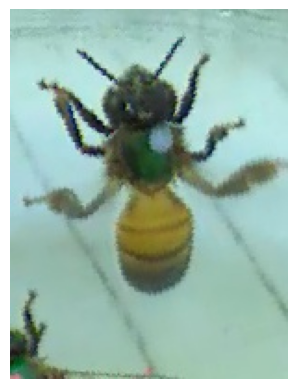

In [37]:
### Visualize predictions
image_to_query = 180
i_tensor = test_dataset[image_to_query]['image']
i_np = np.array(i_tensor)
batch_i_np = np.expand_dims(i_np, axis=0)
i = np.transpose(i_np,[1,2,0])

model = torch.load('/home/lmeyers/ReID_complete/wandb/latest-run/files/model.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if verbose:
    print(f'Device: {device}')
model.to(device)


print('ground truth colors present:',test_dataset[image_to_query]['label'])
with torch.no_grad():
    pred = model(torch.tensor(batch_i_np).to(device))
    print(pred)
print('predicted colors present',torch.round(pred))






plt.imshow(i)
plt.axis('off')
plt.show()



In [38]:
"""

# Import packages and functions
import numpy as np
import pandas as pd
from PIL import Image as Image2
import matplotlib.pyplot as plt
import time
import argparse
import yaml
import pickle
from datetime import datetime

import torch
from pytorch_data import *
from pytorch_models import *


#sys.path.insert(1, '/home/lmeyers/beeid_clean_luke/PYTORCH_CODE/')
#sys.path.insert(2, '/home/lmeyers/beeid_clean_luke/KEY_CODE_FILES/')
import wandb
import os
import torch.nn.parallel
import sys 

def prepare_for_triplet_loss(df, label_col, fname_col):
    # first sort by label value
    sdf = df.sort_values(label_col)
    # then extract labels and filenames from df
    labels = sdf[label_col].values
    filename = sdf[fname_col].values
    # then, make sure dataset has even number of samples
    # given remainder of function, wouldn't it make more sense to ensure each class has an
    # even number of samples?
    if labels.shape[0] % 2:
        labels = labels[1:]
        filename = filename[1:]
        
    # reshape lists into shape (K, 2) for some value K
    # presumably every row [i,:] will contain 2 samples with the same label (assuming even number of samples per label)
    pair_labels = labels.reshape((-1, 2))
    pair_filename = filename.reshape((-1, 2))
    # now permute the row indices
    ridx = np.random.permutation(pair_labels.shape[0])
    # rearrange lists by permuted row indices and flatten back to 1-D arrays
    labels = pair_labels[ridx].ravel()
    filename = pair_filename[ridx].ravel()
    # return as df
    tdf = pd.DataFrame({"filename":filename, "label":labels})
    return tdf
###################################################################################################
##########################################################################################
# FUNCTION TO GET EMBEDDINGS AND LABELS FOR EVALUATING MODEL
def get_predictions(model, dataloader, loss_fn, device, feature_extractor=None):
    predictions = []
    all_labels = []
    loss = 0.0
    with torch.no_grad():
        for k, batch in enumerate(dataloader):
            if feature_extractor is None:
                images = batch['image']
            else:
                images = [transforms.functional.to_pil_image(x) for x in batch['image']]
                images = np.concatenate([feature_extractor(x)['pixel_values'] for x in images])
                images = torch.tensor(images, dtype=torch.float)
            labels = batch['label'].to(device)
            outputs = model(images.to(device))
            loss += loss_fn(outputs, labels).detach().cpu().numpy()
            outputs = outputs.argmax(1)
            predictions += list(outputs.detach().cpu().numpy())
            all_labels += list(labels.detach().cpu().numpy())
    predictions = np.array(predictions)
    all_labels = np.array(all_labels)
    loss/=k
    return predictions, all_labels, loss
##########################################################################################


def train_and_eval(config_file,resume_training=False):
 
    try:
        with open(config_file) as f:
            config = yaml.safe_load(f)
        model_config = config['model_settings'] # settings for model building
        train_config = config['train_settings'] # settings for model training
        data_config = config['data_settings'] # settings for data loading
        eval_config = config['eval_settings'] # settings for evaluation
        torch_seed = config['torch_seed']
        verbose = config['verbose']
    except Exception as e:
        print('ERROR - unable to open experiment config file. Terminating.')
        print('Exception msg:',e)
    if verbose:
        # ADD PRINT OF DATE AND TIME
        now = datetime.now() # current date and time
        dt = now.strftime("%y-%m-%d %H:%M")
        print(f'Date and time when this experiment was started: {dt}')
    

    # setting torch seed
    torch.manual_seed(torch_seed)

    #CREATE TRAIN DATALOADER 

    # READ DATAFRAMES 
    train_fname = data_config['datafiles']['train']
    df_train = pd.read_csv(train_fname)
    dft_train = prepare_for_triplet_loss(df_train, 'ID', 'filename')

    # BUILD DATASET AND DATALOADER
    train_dataset = ColorMap(dft_train, 'filename', 'label',data_config['input_size'],'train','/home/lmeyers/ReID_complete/milticolor_color_map.json')
    bs=64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False)
    batch = next(iter(train_dataloader))

    #CREATE VALID DATALOADER
    ## load validation dataset 
    valid_fname = data_config['datafiles']['valid']
    df_valid = pd.read_csv(valid_fname)
    dft_valid = prepare_for_triplet_loss(df_valid, 'ID', 'filename')

    # BUILD DATASET AND DATALOADER
    valid_dataset = ColorMap(dft_valid, 'filename', 'label',data_config['input_size'],'valid','/home/lmeyers/ReID_complete/milticolor_color_map.json')
    bs=64
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=False)
    batch = next(iter(valid_dataloader))


    ## Build model and load to device:
    num_classes = model_config['num_labels']
    model = build_model(model_config)

    #add color class detector output to model:
    model = nn.Sequential(
        model,
        nn.Linear(128, num_classes),
        nn.Sigmoid())

    optimizer = torch.optim.Adam(model.parameters(), lr=train_config['learning_rate'])
    loss_fn = nn.BCEWithLogitsLoss()

    # LOAD TO DEVICE
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    if verbose:
        print(f'Device: {device}')
    model.to(device)

    #'''
    if resume_training == True: 
        experiment = wandb.init(project="color_detect", entity="lqmeyers",resume=True)
    else:
        experiment = wandb.init(project="color_detect", entity="lqmeyers")
    #'''

    # load latest saved checkpoint if resuming a failed run
    if resume_training == True: 
        saved = os.listdir(os.path.dirname(model_config['model_path'])+r'/checkpoints/')
        check_array = []
        for f in saved:
            check_array.append(f[:-4])
        check_array = np.array(check_array,dtype=np.int64)
        most_recent_epoch = np.max(check_array) #find most recent checkpoint
        print(f'Resuming training from saved epoch: {most_recent_epoch}')
        most_recent_model = os.path.dirname(model_config['model_path'])+r'/checkpoints/'+str(most_recent_epoch)+'.pth'
        print(f'Loading saved checkpoint model {most_recent_model}')
        model = torch.load(most_recent_model)


    # if resuming training set epoch number
    if resume_training == True:
        epoch_range = range(train_config['num_epochs'])[most_recent_epoch:]
    else:
        epoch_range = range(train_config['num_epochs'])

    # Train the model
    if verbose:
        print('Training model...')

    print_k = train_config['print_k']
    start = time.time()
    for epoch in epoch_range: 
        running_loss = 0.0
        for k, data in enumerate(train_dataloader):
            images = data['image'].to(device)
            # get labels
            labels = data['label'].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            #'''
            experiment.log({
                'train loss': loss.item(),
                'epoch': epoch
                #'learning rate' : lr
            })
            #'''
            if (k+1)%print_k == 0:
                with torch.no_grad():
                    predictions = outputs
                    train_acc = torch.logical_and(torch.round(outputs),labels).float().mean()
                    #valid_predictions, valid_labels, valid_loss = get_predictions(model, valid_dataloader, loss_fn, device)
                    #v_acc = []
                    #for v in range(len(valid_predictions)):
                        #v_acc.append(binary_accuracy(torch.round(torch.tensor(valid_predictions[v])),torch.tensor(valid_labels[v])))
                    #valid_acc = torch.mean(torch.tensor(v_acc))
                    #'''
                    experiment.log({'epoch':(epoch+1),
                                    'train loss': (running_loss/print_k),
                                    'train accuracy':train_acc})
                                    #'val_loss': valid_loss,
                                # 'val_acc': valid_acc})
                                    #'''
                    print(f'[{epoch + 1}, {k + 1:5d}] loss: {running_loss/print_k:.4f} | train_acc: {train_acc:.4f}' )# | val_loss: {valid_loss:.4f} | val_acc: {valid_acc:.4f}')
                    running_loss= 0.0
            #'''

        if epoch % train_config['save_checkpoint_freq'] == 0: 
                if os.path.dirname(model_config['model_path']) is not None:
                    print('Saving checkpoint',epoch)
                    if not os.path.exists(os.path.dirname(model_config['model_path'])+r'/checkpoints/'):
                        os.mkdir(os.path.dirname(model_config['model_path'])+r'/checkpoints/')
                    torch.save(model,(os.path.dirname(model_config['model_path'])+r'/checkpoints/'+str(epoch)+".pth"))

    stop = time.time()
    print(f'Total train time: {(stop-start)/60}min')

    # evaluate on test set
    if verbose:
        print('Evaluating model...')
   
    ## load test dataset 
    test_fname = data_config['datafiles']['test']
    df_test = pd.read_csv(test_fname)
    dft_test = prepare_for_triplet_loss(df_test, 'ID', 'filename')

    # BUILD DATASET AND DATALOADER
    test_dataset = ColorMap(dft_test, 'filename', 'label',data_config['input_size'],'test','/home/lmeyers/ReID_complete/milticolor_color_map.json')
    bs=64
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)
    batch = next(iter(test_dataloader))

    # PERFORM INFERENCE
    with torch.no_grad():
        acc = []
        class_acc = {}
        for k, data in enumerate(test_dataloader):
            print(k)
            images = data['image'].to(device)
            # get labels
            labels = data['label'].to(device)
            outputs = model(images)
            matches = torch.logical_and(torch.round(outputs),labels)
            accuracy = (matches.float().mean())
            acc.append(accuracy)
            for i in range(len(labels[0])):
                values_at_index = [subarray[i] for subarray in matches]
                class_mean = torch.tensor(values_at_index).float().mean()
                if k == 0:
                    class_acc[i] = [class_mean]
                else:
                    class_acc[i].append(class_mean)
        for c in class_acc:
            print('Class',c,'Acc:',torch.tensor(class_acc[c]).float().mean())
        print("Total Acc:",torch.tensor(acc).mean())

        '''
        test_predictions, test_labels, test_loss = get_predictions(model, test_dataloader, loss_fn, device, feature_extractor)
        test_acc = np.sum(test_predictions == test_labels)/test_labels.shape[0]
        print(f'Test Loss: {test_loss:.4f}')
        print(f'Test Accuracy: {test_acc:.4f}')
        conf_matrix = confusion_matrix(test_labels, test_predictions)
        print('\nPrinting confusion matrix')
        print(conf_matrix)
        '''
        if model_config['model_path'] is not None:
            print('Saving model...')
            torch.save(model, model_config['model_path'])
        else:
            print('model_path not provided. Not saving model')
        print('Finished')

"""


'\n\n# Import packages and functions\nimport numpy as np\nimport pandas as pd\nfrom PIL import Image as Image2\nimport matplotlib.pyplot as plt\nimport time\nimport argparse\nimport yaml\nimport pickle\nfrom datetime import datetime\n\nimport torch\nfrom pytorch_data import *\nfrom pytorch_models import *\n\n\n#sys.path.insert(1, \'/home/lmeyers/beeid_clean_luke/PYTORCH_CODE/\')\n#sys.path.insert(2, \'/home/lmeyers/beeid_clean_luke/KEY_CODE_FILES/\')\nimport wandb\nimport os\nimport torch.nn.parallel\nimport sys \n\ndef prepare_for_triplet_loss(df, label_col, fname_col):\n    # first sort by label value\n    sdf = df.sort_values(label_col)\n    # then extract labels and filenames from df\n    labels = sdf[label_col].values\n    filename = sdf[fname_col].values\n    # then, make sure dataset has even number of samples\n    # given remainder of function, wouldn\'t it make more sense to ensure each class has an\n    # even number of samples?\n    if labels.shape[0] % 2:\n        labels = 

In [39]:
resume_training = False
config_file = '/home/lmeyers/ReID_complete/pytorch_train_and_eval_color_detect.yml'

#train_and_eval(config_file,resume_training)